## Google QUEST Q&A Labeling

Improving automated understanding of complex question answer content


## LSTM

In [1]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pickle
#from transformers import 
import numpy as np
from numpy import zeros
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
import random as rn

from wordcloud import WordCloud, STOPWORDS 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

import tensorflow
from tensorflow.keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Input,concatenate,Activation,Dropout,BatchNormalization,LSTM
from tensorflow.keras import regularizers,Model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler


from matplotlib_venn import venn2, venn2_unweighted
from matplotlib_venn import venn3, venn3_unweighted
%matplotlib inline

In [4]:
# reading train data from csv file

train = pd.read_csv("../input/google-quest-challenge/train.csv")
print(train.shape)
train.head()

(6079, 41)


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [5]:
train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [6]:
# reading test data from csv file
test = pd.read_csv("../input/google-quest-challenge/test.csv")
print(test.shape)
test.head()

(476, 11)


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [7]:
sample = pd.read_csv("../input/google-quest-challenge/sample_submission.csv")
class_labels = list(sample.columns)[1:]
print("Number of class labels = ",len(class_labels))
class_labels

Number of class labels =  30


['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [8]:
input_col = list(test.columns)
input_col.remove('qa_id')
input_col

['question_title',
 'question_body',
 'question_user_name',
 'question_user_page',
 'answer',
 'answer_user_name',
 'answer_user_page',
 'url',
 'category',
 'host']

In [9]:
# checking if there are any missing values
train.isna().sum()

qa_id                                    0
question_title                           0
question_body                            0
question_user_name                       0
question_user_page                       0
answer                                   0
answer_user_name                         0
answer_user_page                         0
url                                      0
category                                 0
host                                     0
question_asker_intent_understanding      0
question_body_critical                   0
question_conversational                  0
question_expect_short_answer             0
question_fact_seeking                    0
question_has_commonly_accepted_answer    0
question_interestingness_others          0
question_interestingness_self            0
question_multi_intent                    0
question_not_really_a_question           0
question_opinion_seeking                 0
question_type_choice                     0
question_ty

### EDA

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# plotting Wordcloud of question title

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the question title 
for val in train.question_title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the above Wordcloud, it can be said that most occuring words in Question title are `using, file, use, value, user, one, time, change, window, function, data`

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# plotting Wordcloud of question body

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the question body  
for val in train.question_body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the above Wordcloud, it can be said that most occuring words in Question body are `gt, lt, one, will, using, use, example,know, question, new, work, value, problem`

In [ ]:
# plotting Wordcloud of (question body + question title)

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the question title 
for val in train.question_title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

# iterate through the question body 
for val in train.question_body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "


  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Some of the most occuring words in Question body and title combined are `gt, lt, one, will, use, file, want, example, know, question, using, new, work, problem`

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# plotting Wordcloud of answers

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train.answer: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the above Wordcloud, it can be said that most occuring words in Question title are `use, one, will, need, gt, lt, using, file, time, gt, lt, way, make, example, see`

In [ ]:
# taking set of all words in question title
q_title_set = set([word for question in train.question_title for word in question.split(' ')])

# taking set of all words in question body
q_body_set = set([word for question in train.question_body for word in question.split(' ')])

# taking set of all words in answer
answer_set = set([word for answer in train.answer for word in answer.split(' ')])

In [ ]:
# https://pypi.org/project/matplotlib-venn/
# venn diagram of (set of words in Question title) vs (set of words in Question body)

venn2([q_title_set,q_body_set], set_labels=("Question title","Question body"))
plt.title("Venn diagram of (set of words in Question title) vs (set of words in Question body)")


##### There is a good overlap between Question title and Question body. Out of 10492 words in Question title, 7027 are common with Question body.

In [ ]:
# venn diagram of (set of words in answer) vs (set of words in Question body)

h = venn2([answer_set,q_body_set], set_labels=("Answer","Question body"))
plt.title("Venn diagram of (set of words in Answer) vs (set of words in Question body)")


##### Out of 77578 words in Question body, 25859 words i.e. nearly 33% are common with answer.

In [ ]:
# venn diagram of (set of words in answer) vs (set of words in Question body)

h = venn2([answer_set,q_title_set], set_labels=("Answer","Question title"))
plt.title("Venn diagram of (set of words in Answer) vs (set of words in Question title)")


##### Answer and Question title also have a good overlap. 90% of the words in Question title are present in Answers.

In [ ]:
# venn diagram of (set of words in Question title) vs (set of words in Question body) vs (set of words in answer)
venn3_unweighted([q_title_set,q_body_set,answer_set],('Question title', 'Question body', 'Answer'))

In [ ]:
#plot of category count 

plt.figure(figsize=(20,10))
ax = sns.countplot(train.category, order=train.category.value_counts().index)
plt.xlabel("Category")
plt.ylabel("Number of Questions")
plt.title("Category vs Number of Questions")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### Maximum number of questions have category `TECHNOLOGY` which is 40.2% of total number of questions.
##### 20.6% of total questions are `STACKOVERFLOW`.
##### 15.6% questions falls under `CULTURE`.
##### `SCIENCE` and `LIFE_ARTS` are minimum with 11.7% each.

In [10]:
# preprocessing host name 

train['host'] = train['host'].apply(lambda x: x.split('.')[-2])

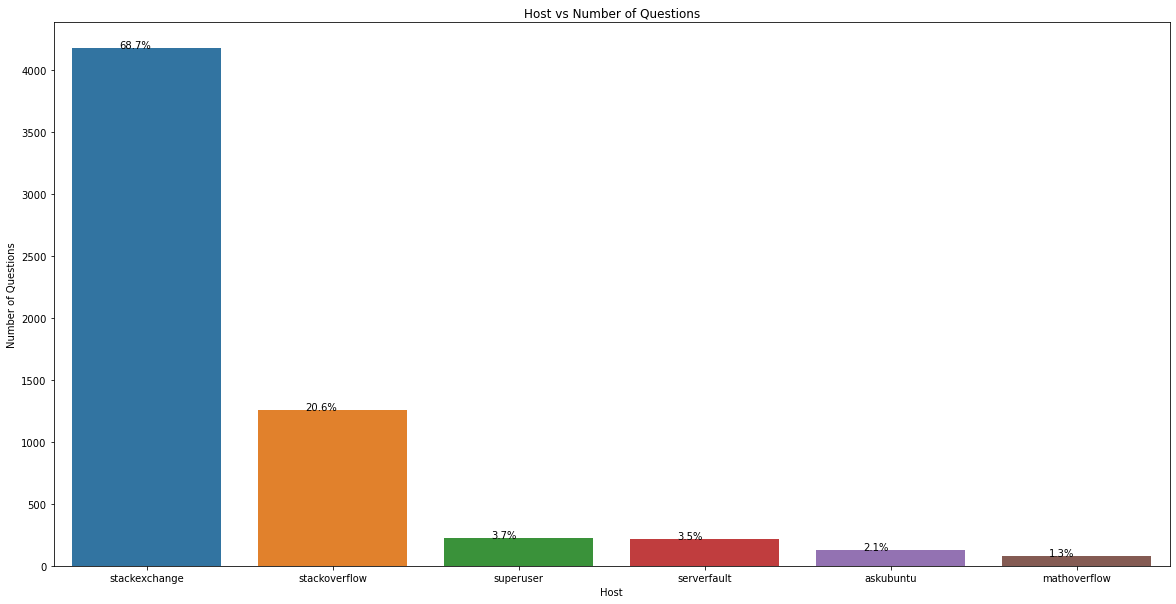

In [15]:
#plot of host count 

plt.figure(figsize=(20,10))
ax = sns.countplot(train.host, order=train.host.value_counts().index)
plt.xlabel("Host")
plt.ylabel("Number of Questions")
plt.title("Host vs Number of Questions")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### The above plot shows that `stackexchange` hosted maximum questions with 68.6% of total questions.
##### Host with 2nd highest number of questions is `stackoverflow`.
##### Other hosts are`superuser` with 3.7%, `serverfault` with 3.5%, `askubuntu` with 2.1% and `mathoverflow` 1.3%.

In [11]:
# taking length of question title, question body, answer
train['q_title_length'] = train['question_title'].apply(lambda x: len(x.split(' ')))
train['q_body_length'] = train['question_body'].apply(lambda x: len(x.split(' ')))
train['answer_length'] = train['answer'].apply(lambda x: len(x.split(' ')))
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,q_title_length,q_body_length,answer_length
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,13,139,149
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,16,144,72
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,7,117,188
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,8,73,258
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,9,80,24


In [ ]:
# kde plot of length of question title
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_title_length'], shade=True, ax=ax1)
plt.xlabel('Length of Question title')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_title_length'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Length of Question title')
plt.title('CDF')
plt.grid()
plt.show()


##### In the PDF plot, it can be observed that maximum number of questions titles have length around 7 or 8.
##### CDF plot shows that 90% of questions have length less than 15

In [ ]:
# kde plot of length of question title
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_length'], shade=True, ax=ax1)
plt.xlabel('Length of Question body')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_length'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Length of Question body')
plt.grid()
plt.title('CDF')

plt.show()


##### In the PDF plot, it can be observed that almost all questions body have length less than 500. But there are few questions body with length around 1000.
##### CDF plot shows that more than 90% of questions have length less than 500

In [ ]:
# kde plot of length of question title
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_length'], shade=True, ax=ax1)
plt.xlabel('Length of answers')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_length'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Length of answers')
plt.grid()
plt.title('CDF')

plt.show()


##### In the PDF plot, it can be observed that almost all answersy have length less than 1000. But there are few questions body with length around 2000 and even 8000.
##### CDF plot shows that more than 90% of questions have length less than 1000.

In [ ]:
# kde plot of question_asker_intent_understanding
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_asker_intent_understanding'], shade=True, ax=ax1)
plt.xlabel('Questions asker intent')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_asker_intent_understanding'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Questions asker intent')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 25% of the questions have intent score less than 0.8 i.e. most of the question's intent are clear upto good extent.
##### Also maximum questions have intent score around 1 and 0.9

In [ ]:
# kde plot of question_type_reason_explanation
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_type_reason_explanation'], shade=True, ax=ax1)
plt.xlabel('Questions reason explanation')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_type_reason_explanation'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Questions reason explanation')
plt.grid()
plt.title('CDF')

plt.show()


##### Maximum questions type have reason explanation score 0.
##### 80% of the questions have reason explanation score less than 0.8

In [ ]:
# kde plot of question_well_written
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_well_written'], shade=True, ax=ax1)
plt.xlabel('Questions well written')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_well_written'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Questions well written')
plt.grid()
plt.title('CDF')

plt.show()


#### Plot shows that most of the questions are well written with score between 0.8 to 1

In [ ]:
# count of each score for "question_not_really_a_question"
train['question_not_really_a_question'].value_counts()

##### There are very few question who are not really a question. There are 3 questions having score 1

In [ ]:
# kde plot of question_interestingness_others
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_interestingness_others'],  ax=ax1, color='green')
sns.kdeplot(train['question_interestingness_self'], ax=ax1, color='gold')
plt.xlabel('Questions interestingness')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_interestingness_others'], cumulative=True, ax=ax2, color = 'green')
sns.kdeplot(train['question_interestingness_self'], cumulative=True, ax=ax2, color= 'gold')
plt.xlabel('Questions interestingness')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of  the questions have high score for question_interestingness_others, than question_interestingness_self  scores. That means most of the questions are more interesting to others

In [ ]:
# kde plot of Question expect short answer
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_expect_short_answer'], shade=True, ax=ax1)
plt.xlabel('Question expect short answer')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_expect_short_answer'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question expect short answer')
plt.grid()
plt.title('CDF')

plt.show()


##### 50% of the question_asker_intent_understanding have value less than 0.8, but most of the questions have value 1. There are few questions with value 0.

In [ ]:
# kde plot of answer_helpful
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_helpful'], shade=True, ax=ax1)
plt.xlabel('Answer helpful rating')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_helpful'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer helpful rating')
plt.grid()
plt.title('CDF')

plt.show()


##### From the above plots, it can be said that most of the answers have helpful score 1. 
##### Around 35% of the answers have answer_helpful score less than 0.9

In [ ]:
# kde plot of answer_satisfaction
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_satisfaction'], shade=True, ax=ax1)
plt.xlabel('Answer satisfaction rating')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_satisfaction'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer satisfaction rating')
plt.grid()
plt.title('CDF')

plt.show()


##### Only 30% of the answers have answer_satisfaction score less than 0.8.  Most of the answers have score between 0.8 to 1. So maximum number of answers are satisfactory. 

In [ ]:
# kde plot of answer_well_written
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_well_written'], shade=True, ax=ax1)
plt.xlabel('Answer well written score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_well_written'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer well written score')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of the questions have well written score of 0.9 and 1.
##### Only around 18% of the questions have well written score less than 0.8

In [ ]:
# BoxPlot of question_asker_intent_understanding
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_asker_intent_understanding,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("Question asker's intent")
plt.title("Category vs Question asker's intent")

Most of the `life_arts` category questions have a good understanding of question asker's intent with a score between 0.8 to 1.

`culture` category questions also have the same scores as `life_arts`

Categories `science, stackoverflow, technology` have 75% of the questions asker's intent score between 0.78 to 1, but there are still 25% questions with score between 0.3 to 0.75.

In [ ]:
# BoxPlot of question_body_critical
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_conversational,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("Conversational Questions")
plt.title("Category vs Conversational Questions")

##### Can't get enough info out of above plot

In [ ]:
# BoxPlot of question_expect_short_answer
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_expect_short_answer,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_expect_short_answer")
plt.title("Category vs Questionsexpect short answers")

##### From above plot, it can be said that mostly questions under categories `culture, stackoverflow, technology` expects short answers.

In [ ]:
# BoxPlot of question_interestingness_others
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_interestingness_others,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_interestingness_others")
plt.title("Category vs Questions interesting to others")

##### It seems `'life_arts` category questions are more interesting to others than other categories

In [ ]:
# BoxPlot of question_interestingness_self
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_interestingness_self,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_interestingness_self")
plt.title("Category vs question_interestingness_self")

Categories `life_arts` and `culture` have higher score for `question_interestingness_self` than others.

`stackoverflow` have the lowest scores

In [ ]:
# BoxPlot of question_well_written
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_well_written,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_well_written")
plt.title("Category vs question_well_written")

`life_arts` and `culture` have more well written questions  than other categories. 
`science` also has well written questions compared to `stackoverflow` and `technology`

In [ ]:
# BoxPlot of answer_well_written
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.answer_well_written,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("answer_well_written")
plt.title("Category vs answer_well_written")

Answers of all categories are well written except for few outliers with value less than 0.5.
`stackoverflow` have some answers with well written score less compared to others 

In [ ]:
# BoxPlot of answer_satisfaction
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.answer_satisfaction,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("answer_satisfaction")
plt.title("Category vs answer_satisfaction")

So all the categories have more or less equal answer satisfaction scores.

In [ ]:
# function to plot distribution of class-labels for each of 5 category
def dist_plot_category(class_labels,column_name):
    colours = ['r','g','b','m','y']
    fig = plt.figure(figsize=(35,35))
    for cat,color in zip(set(train[column_name]),colours):
        #plt.colorbar()
        
        i=1
        for col in class_labels:
            fig.add_subplot(6,5,i)
            sns.distplot(train[train['category']==cat][col],color=color,hist=False)
            
            i+=1
        

In [ ]:
warnings.filterwarnings("ignore")
dist_plot_category(class_labels=class_labels,column_name='category')
plt.title("Distribution of each class label for each category")

In [ ]:
# function to plot distribution of class-labels
def dist_plot(class_labels, filter_col, filter_value,color='green'):
    fig = plt.figure(figsize=(35,35))
    i=1
    j=1
    for col in class_labels:
        fig.add_subplot(6,5,i)
        sns.distplot(train[train[filter_col]==filter_value][col],color=color)
        i+=1
        

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='LIFE_ARTS')
plt.title("Distribution of each class label for category 'LIFE_ARTS'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='CULTURE',color='blue')
plt.title("Distribution of each class label for category 'CULTURE'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='SCIENCE',color='m')
plt.title("Distribution of each class label for category 'SCIENCE'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='STACKOVERFLOW',color='cyan')
plt.title("Distribution of each class label for category 'STACKOVERFLOW'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='TECHNOLOGY',color='green')
plt.title("Distribution of each class label for category 'TECHNOLOGY'")

From all the category plots, `cultural` and `life_arts` have more converstaional questions than other categories.

Class label `question_interestingness_self` have higher score for categories `life_arts` and `cultural` for most questions.

Categories `stackoverflow` and `technology` have less reason explanation type answers, whereas `science` have more questions compared to others for reason explanation type answers


In [ ]:
set(train.host)

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='askubuntu',color='green')
plt.title("Distribution of each class label for host 'askubuntu'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='mathoverflow',color='green')
plt.title("Distribution of each class label for host 'mathoverflow'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='serverfault',color='green')
plt.title("Distribution of each class label for host 'serverfault'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='stackexchange',color='green')
plt.title("Distribution of each class label for host 'stackexchange'")

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='stackoverflow',color='green')
plt.title("Distribution of each class label for host 'stackoverflow'")

For host `stackoverflow`, most of the questions have `question_conversational` score 0 i.e most questions are not conversational.

`question_well_written` score are well distributed between 0.4 to 1.

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='superuser',color='green')
plt.title("Distribution of each class label for host 'superuser'")

For all the hosts above, very few questions have `question_type_reason_explanation` close to 1.



### Preprocessing

In [ ]:
train.head()

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't , gt,lt"]
            


In [ ]:
import re

def preprocess_text(phrase):
    # specific
    phrase = str(phrase)
    phrase = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrade = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"cannot", "can not", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\', ' ')
    
    #phrase = re.sub(r'http\S+', '', phrase)  # for removal all http link
    phrase = re.sub(r'[^A-Za-z0-9]', ' ',phrase) # remove everything except alphaets and numbers
    
    senten=''
    for val in phrase.split():           # this for loop will remove the stopwords and words having only numbers 
        pattern = re.match(r"[0-9]",val)
        if (pattern) or (val in stopwords):      
            continue
        else:
            senten = senten + ' ' +val
            
    senten = senten.strip()            # removing space from string start and end
    return senten
    


In [12]:
###try

# https://stackoverflow.com/a/47091490/4084039
import re

def preprocess_text(phrase):
    # specific
    phrase = str(phrase)
    phrase = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrade = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"cannot", "can not", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\', ' ')
    
    #phrase = re.sub(r'http\S+', '', phrase)  # for removal all http link
    phrase = re.sub(r'[^A-Za-z0-9]', ' ',phrase) # remove everything except alphaets and numbers
    
    sent = ''
    for val in phrase.split():          # removing multiple spaces between words
        sent = sent + ' ' + val
    sent = sent.strip()
    
    return sent
    


In [13]:
# preprocessing question title, question body and answers
train['question_title'] = train['question_title'].apply(lambda x: preprocess_text(x))
train['question_body'] = train['question_body'].apply(lambda x: preprocess_text(x))
train['answer'] = train['answer'].apply(lambda x: preprocess_text(x))

print(len(train['question_title']))
print(train['question_title'][0])
print("="*50)

print(train['question_body'][0])
print("="*50)

print(train['answer'][0])
print("="*50)

6079
what am i losing when using extension tubes instead of a macro lens
after playing around with macro photography on the cheap read reversed lens rev lens mounted on a straight lens passive extension tubes i would like to get further with this the problems with the techniques i used is that focus is manual and aperture control is problematic at best this limited my setup to still subjects read dead insects now as spring is approaching i want to be able to shoot live insects i believe that for this autofocus and settable aperture will be of great help so one obvious but expensive option is a macro lens say ef 100mm macro however i am not really interested in yet another prime lens an alternative is the electrical extension tubes except for maximum focusing distance what am i losing when using tubes coupled with a fine lens say ef70 200 2 8 instead of a macro lens
i just got extension tubes so here is the skinny what am i losing when using tubes a very considerable amount of light inc

In [14]:
# preprocessing 'category' and 'host' to lower-case and stripping leading and tailing spaces 

train['category'] = train['category'].apply(lambda x: x.lower())
train['category'] = train['category'].apply(lambda x: x.strip())

train['host'] = train['host'].apply(lambda x: x.lower())
train['host'] = train['host'].apply(lambda x: x.strip())

### Feature Engineering

I have already created 3 features in the EDA section - 
1. `q_title_length` - Length of question title
2. `q_body_length` - Length of question body
3. `answer_length` - Length of answer

#### Features - Sentiment scores of the question_title, question_body and answer

In [15]:
# sentiments from question_title

#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for title in train.question_title:
    ss = sid.polarity_scores(title)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

train['q_title_neg'] = neg
train['q_title_neu'] = neu
train['q_title_pos'] = pos
train['q_title_comp'] = comp

print(train.shape)

(6079, 48)


In [16]:
# sentiments from question_body
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in train.question_body:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
train['q_body_neg'] = neg
train['q_body_neu'] = neu
train['q_body_pos'] = pos
train['q_body_comp'] = comp

print(train.shape)

(6079, 52)


In [17]:
# sentiments from answer
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in train.answer:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
train['q_answer_neg'] = neg
train['q_answer_neu'] = neu
train['q_answer_pos'] = pos
train['q_answer_comp'] = comp

print(train.shape)

(6079, 56)


#### EDA on new features 

In [18]:
# function to get the percentile values by passing dataframe and column
def percentile(data,column,min_lim=1,max_lim=101,diff=3):
    for i in np.arange(min_lim,max_lim,diff):
        print(f"{i} percentile = ",np.percentile(data[column], i))

In [19]:
percentile(train, column='q_title_neg')

1 percentile =  0.0
4 percentile =  0.0
7 percentile =  0.0
10 percentile =  0.0
13 percentile =  0.0
16 percentile =  0.0
19 percentile =  0.0
22 percentile =  0.0
25 percentile =  0.0
28 percentile =  0.0
31 percentile =  0.0
34 percentile =  0.0
37 percentile =  0.0
40 percentile =  0.0
43 percentile =  0.0
46 percentile =  0.0
49 percentile =  0.0
52 percentile =  0.0
55 percentile =  0.0
58 percentile =  0.0
61 percentile =  0.0
64 percentile =  0.0
67 percentile =  0.0
70 percentile =  0.0
73 percentile =  0.0
76 percentile =  0.0
79 percentile =  0.0
82 percentile =  0.0
85 percentile =  0.1283000000000002
88 percentile =  0.189
91 percentile =  0.238
94 percentile =  0.278
97 percentile =  0.355
100 percentile =  0.76


In [20]:
percentile(train, 'q_title_neg',85,100,1)

85 percentile =  0.1283000000000002
86 percentile =  0.149
87 percentile =  0.172
88 percentile =  0.189
89 percentile =  0.20742000000000005
90 percentile =  0.22
91 percentile =  0.238
92 percentile =  0.252
93 percentile =  0.268
94 percentile =  0.278
95 percentile =  0.302
96 percentile =  0.326
97 percentile =  0.355
98 percentile =  0.40187999999999924
99 percentile =  0.470880000000001


##### 82% of question title have negative score = 0 i.e. they are not negative.

In [ ]:
# kde plot of q_title_neu
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_title_neu'], shade=True, ax=ax1)
plt.xlabel('Question title neutral score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_title_neu'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question title neutral score')
plt.grid()
plt.title('CDF')

plt.show()


##### Maximum number of questions have neutral score 1. 

In [ ]:
# percentiles of q_title_neu (neutral rating of question title)
percentile(train, 'q_title_neu',1,100,2)

##### All question titles have neutral score greater than 0 i.e. all questions are somewhat neutral.
##### 65% of question titles have neutral score 1.

In [ ]:
percentile(train, 'q_title_pos',1,100,2)

In [ ]:
percentile(train, 'q_title_pos',99,100.1,0.1)

##### 75% questions have positive score 0 i.e. they are not positive.
##### Maximum positive score a question has 0.99

In [ ]:
# kde plot of q_body_neg
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_neg'], shade=True, ax=ax1)
plt.xlabel('Question body negative score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_neg'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question body negative score')
plt.grid()
plt.title('CDF')

plt.show()


In [ ]:
percentile(train, 'q_body_neg')

##### Maximum negative score of a question body is 0.605. Around 31% of questions have negative score 0 i.e. they are not negative.

In [ ]:
# kde plot of q_body_neu
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_neu'], shade=True, ax=ax1)
plt.xlabel('Question body neutral score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_neu'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question body neural score')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of the questions body have neutral score greater than 0.8
##### About 50% of the questions have neutral score less than 0.8

In [ ]:
percentile(train, 'q_body_neu')

##### All question body have neutral score greater than 0.4
#####  51% of the questions body have neutral score greater than 0.8

In [ ]:
# kde plot of q_body_pos
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_pos'], shade=True, ax=ax1)
plt.xlabel('Question body positive score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_pos'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question body positive score')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 40% of the questions body have score less than 0.1

In [ ]:
percentile(train, 'q_body_pos')

##### Maximum positive score of a question body is 0.667.
##### 95% of the questions body have a positive score less than 0.3 i.e. most of the questions body are not much positive.

In [ ]:
# kde plot of q_answer_neg
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_answer_neg'], shade=True, ax=ax1)
plt.xlabel('Answer negative score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_answer_neg'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer negative score')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of the answers have negative score 0

In [ ]:
percentile(train,'q_answer_neg')

##### 35% of the answers have negative score 0. 
##### 75% of the answers have negative score less than 0.1, that means maximum answers have very less negative score.
##### Maximum negative score of an answer is 0.675.

In [ ]:
# kde plot of q_answer_neu
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_answer_neu'], shade=True, ax=ax1)
plt.xlabel('Answer neutral score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_answer_neu'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer neutral score')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 50% of the answers have neutral score greater than 0.8

In [ ]:
percentile(train,'q_answer_neu')

Most answers are highly neutral

In [ ]:
# kde plot of q_answer_pos
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_answer_pos'], shade=True, ax=ax1)
plt.xlabel('Answer positive score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_answer_pos'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer positive score')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 78% of the answers have positive score upto 0.2, so most answers are not so positive

In [ ]:
# percentiles of answer positive score
percentile(train,'q_answer_pos')

##### Maximum positive score of an answer is 0.857.
##### Around 91% of the answer have a positive score upto 0.29 i.e. most of the answers are not much positive.

### Splitting train data into train, cross-validation set

In [ ]:
train.columns

In [21]:
# input columns to be used for training model
input_columns = ['question_title', 'question_body','answer','category', 'host','q_title_length', 'q_body_length',
                 'answer_length', 'q_title_neg', 'q_title_neu', 'q_title_pos','q_title_comp', 'q_body_neg', 'q_body_neu', 
                 'q_body_pos', 'q_body_comp','q_answer_neg', 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']


In [22]:
X = train[input_columns].copy()
Y = train[class_labels].copy()

print(X.shape,Y.shape)


(6079, 20) (6079, 30)


In [23]:
from sklearn.model_selection import train_test_split
x_train,x_cv,y_train,y_cv = train_test_split(X,Y, test_size=0.1)
print("Shape after split")
print("Train shape = ", x_train.shape, y_train.shape)
print("Test shape = ", x_cv.shape, y_cv.shape)

Shape after split
Train shape =  (5471, 20) (5471, 30)
Test shape =  (608, 20) (608, 30)


### Encoding categorical data

In [24]:
# one-hot encoding 'category' feature
category_ohe = CountVectorizer(binary=True)
category_ohe.fit(x_train['category'])
category_encoded_train = category_ohe.transform(x_train['category']).todense()
category_encoded_cv = category_ohe.transform(x_cv['category']).todense()

print("Shape of train after encoding = ",category_encoded_train.shape)
print("Shape of cv after encoding = ",category_encoded_cv.shape)

Shape of train after encoding =  (5471, 5)
Shape of cv after encoding =  (608, 5)


In [25]:
# one-hot encoding 'host'
host_ohe = CountVectorizer(binary=True)
host_ohe.fit(x_train['host'])
host_encoded_train = host_ohe.transform(x_train['host']).todense()
host_encoded_cv = host_ohe.transform(x_cv['host']).todense()

print("Shape of train after encoding = ",host_encoded_train.shape)
print("Shape of cv after encoding = ",host_encoded_cv.shape)

Shape of train after encoding =  (5471, 6)
Shape of cv after encoding =  (608, 6)


### Encoding Text data

#### Using Pretrained Models: Avg W2V

In [ ]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================

words = []
for i in train['question_title']:
    words.extend(i.split(' '))

for i in train['question_body']:
    words.extend(i.split(' '))
    
for i in train['answer']:
    words.extend(i.split(' '))

print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

# saving variables into a pickle file
with open('glove_vectors_sw', 'wb') as f:
    pickle.dump(words_courpus, f)

In [26]:
# reading glove_vectors pickle file
with open('../input/glove-vec/glove_vectors_sw', 'rb') as f:
    glove_vector = pickle.load(f)
    glove_words =  set(glove_vector.keys())

In [27]:
# average Word2Vec on question title train data
# computing average word2vec for each question title
avg_w2v_vectors_title_train = []; # the avg-w2v for each question title is stored in this list
for sentence in tqdm(x_train['question_title']): # for each question title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question title
    for word in sentence.split(): # for each word in a question title
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_train.append(vector)

print(len(avg_w2v_vectors_title_train))
print(len(avg_w2v_vectors_title_train[0]))
print(avg_w2v_vectors_title_train[0])

100%|██████████| 5471/5471 [00:00<00:00, 22436.28it/s]

5471
300
[ 1.64727692e-01 -4.59757692e-02 -1.50027923e-01 -1.90242769e-01
  1.83442154e-01  1.65900462e-01 -3.43772462e+00  5.16896923e-01
 -2.33952308e-02 -2.90199412e-01  9.16001846e-02 -4.83976077e-02
 -9.45620000e-02 -8.88867154e-02  7.21796923e-02 -1.15775100e-01
 -3.17739462e-01 -3.76377692e-02  1.05340869e-02  3.29356154e-03
 -9.46256154e-02  2.09441654e-02  5.43830769e-03 -4.63223846e-02
  5.12043846e-02 -2.65704615e-01  3.45151538e-02 -1.89961446e-01
 -1.08648392e-01 -2.64158762e-01 -1.07462031e-01  5.74815385e-02
  5.30039231e-02 -1.52692385e-01 -1.67131154e-01 -6.32578846e-02
 -1.16893577e-01 -8.61210400e-02  8.01764092e-02 -2.17952308e-02
 -9.28490000e-02 -9.17992308e-03 -1.77419154e-01 -2.62596692e-01
  1.03670769e-02 -6.16856154e-02 -2.12778692e-02 -4.37582308e-02
 -5.73906154e-02 -7.61547692e-02 -1.19100077e-01  9.02662308e-02
 -9.59820769e-02 -3.89924615e-02 -1.30807692e-01 -1.59371238e-01
 -1.09581769e-01  5.03935385e-02 -1.00709000e-01  3.60418462e-02
 -4.12824615e-02

In [28]:
# average Word2Vec on question title cross-validation data
# computing average word2vec for each question title
avg_w2v_vectors_title_cv = []; # the avg-w2v for each question title is stored in this list
for sentence in tqdm(x_cv['question_title']): # for each question title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question title
    for word in sentence.split(): # for each word in a question title
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_cv.append(vector)

print(len(avg_w2v_vectors_title_cv))
print(len(avg_w2v_vectors_title_cv[0]))
print(avg_w2v_vectors_title_cv[0])

100%|██████████| 608/608 [00:00<00:00, 22283.81it/s]

608
300
[-1.02702500e-01 -1.24952500e-01  4.60032500e-02  4.61875000e-02
 -2.13337500e-02 -2.42090000e-01 -2.20487250e+00 -8.01335000e-02
  8.95940000e-02 -3.05692500e-01  2.31213250e-01 -1.60452500e-01
 -3.10460500e-01 -8.12286000e-02  1.65948750e-01  7.72487500e-02
 -8.42195000e-02  1.32220000e-01  7.30650000e-02  1.97406750e-01
  5.35622500e-01  1.05915000e-02  6.88375000e-02  1.50225000e-01
 -1.19860000e-01  8.07025000e-02  1.05769000e-01 -4.10766000e-01
  6.94575000e-03 -1.11838500e-01  6.55072500e-02 -2.08339500e-01
 -2.30932500e-01  2.89742500e-01 -3.59192500e-02 -2.40535000e-01
  2.53209250e-01  9.28500000e-04  2.03382750e-01 -3.29990000e-02
 -1.65735000e-01  1.34780000e-02 -1.38507500e-02 -4.03552500e-01
  1.55301175e-01  3.35280000e-01 -1.66436750e-01 -1.85878875e-01
 -4.93915000e-01  4.26075000e-02  1.29445650e-01  1.74497500e-01
 -1.86195000e-02 -5.18800000e-03 -2.53217500e-01 -4.64127500e-02
  3.98167500e-02 -3.43334500e-01  3.12283250e-01 -1.14772250e-02
  3.81703000e-01 

In [29]:
# average Word2Vec on question body train data
# computing average word2vec for each question body
avg_w2v_vectors_body_train = []; # the avg-w2v for each question body is stored in this list
for sentence in tqdm(x_train['question_body']): # for each question body
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question body
    for word in sentence.split(): # for each word in a question body
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_body_train.append(vector)

print(len(avg_w2v_vectors_body_train))
print(len(avg_w2v_vectors_body_train[0]))
print(avg_w2v_vectors_body_train[0])

100%|██████████| 5471/5471 [00:01<00:00, 2951.11it/s]

5471
300
[ 4.98794606e-02 -2.12572411e-02 -6.48565844e-02 -1.26463426e-01
  2.03091624e-01  3.57973348e-02 -3.53638298e+00  4.79139163e-01
  7.07632823e-02 -2.95747733e-01  5.81099929e-02  3.62829177e-02
 -7.21722624e-03 -4.04728241e-02  4.52131773e-02 -1.52853888e-01
 -1.64983765e-01 -6.29017759e-02  4.54168277e-02  1.35403305e-02
  3.51126809e-02 -2.66981947e-02 -1.54867447e-02 -1.97913149e-02
 -5.24133074e-02 -2.12453631e-01 -4.84618730e-02 -1.35368788e-01
 -1.28808004e-01 -1.01439223e-01 -1.41787845e-01  4.09677773e-02
  1.53688397e-02 -1.32905341e-01 -5.87119730e-02 -3.81824965e-02
 -7.55141689e-02 -1.69814813e-01  1.09284373e-01  2.21162980e-02
 -7.57650377e-02  4.12727879e-02 -9.04703525e-02 -2.01967016e-01
  2.91163262e-03 -5.60526809e-02  1.32698546e-02 -6.87434596e-02
 -5.89876965e-02 -5.25707943e-02 -5.52308809e-02  9.06011064e-02
 -8.61252950e-02 -1.87256170e-03 -3.02115149e-02 -1.14445507e-01
  5.68741702e-03  1.62356028e-02 -6.83021369e-02  6.16429078e-02
  4.69765035e-02

In [30]:
# average Word2Vec on question body test data
# computing average word2vec for each question body
avg_w2v_vectors_body_cv = []; # the avg-w2v for each question body is stored in this list
for sentence in tqdm(x_cv['question_body']): # for each question body
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question body
    for word in sentence.split(): # for each word in a question body
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_body_cv.append(vector)

print(len(avg_w2v_vectors_body_cv))
print(len(avg_w2v_vectors_body_cv[0]))
print(avg_w2v_vectors_body_cv[0])

100%|██████████| 608/608 [00:00<00:00, 3160.16it/s]

608
300
[-4.77066206e-02 -3.67971991e-02 -7.95059230e-02 -1.45002847e-01
  1.14980955e-01 -6.46524503e-02 -3.53642534e+00  3.09715303e-01
  6.57084185e-03 -3.66188867e-01  1.11071671e-01 -4.56330904e-02
 -9.22942303e-03 -5.77239489e-02  2.74830337e-03 -8.23516256e-02
 -1.15281087e-01 -1.48810499e-02  8.16607815e-02  7.59273249e-02
  1.17264192e-01 -6.63509849e-02  3.98944310e-02 -3.58635242e-02
 -4.68213350e-02 -1.14332487e-01 -1.20661500e-02 -1.41242496e-01
 -4.21282062e-02  2.79500882e-03 -1.52101680e-01 -8.57789326e-03
  1.05387602e-01 -2.28425044e-02 -5.07341489e-02 -8.58146067e-04
  1.16952084e-02 -7.90263039e-02  1.77858287e-01 -1.01621338e-01
  8.52448365e-03  6.53265354e-02 -3.54712899e-02 -2.10438234e-01
  6.77647191e-03  1.24100820e-02  3.55606202e-02 -1.64803879e-01
 -7.43726140e-02  1.05413230e-02 -3.92168803e-02 -1.13082225e-02
 -3.11190880e-02 -7.60509051e-02 -4.59721067e-03 -8.48952081e-02
  5.44735753e-02 -6.78040983e-02  8.33929607e-03  5.35119488e-02
  8.96809708e-02 

In [31]:
# average Word2Vec on answer train data
# computing average word2vec for each answer
avg_w2v_vectors_answer_train = []; # the avg-w2v for each answer is stored in this list
for sentence in tqdm(x_train['answer']): # for each answer
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the answer
    for word in sentence.split(): # for each word in a answer
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_answer_train.append(vector)

print(len(avg_w2v_vectors_answer_train))
print(len(avg_w2v_vectors_answer_train[0]))
print(avg_w2v_vectors_answer_train[0])

100%|██████████| 5471/5471 [00:01<00:00, 3066.35it/s]

5471
300
[ 8.61519512e-03 -9.29324024e-04 -1.57759990e-01 -1.36909321e-01
  1.91203122e-01 -3.76685244e-03 -3.64999366e+00  4.91381598e-01
  3.52693829e-02 -3.36133029e-01  5.57536098e-02  5.93754634e-03
  4.50884146e-03 -1.15222299e-01  2.01714793e-02 -1.22932144e-01
 -8.16006524e-02 -6.26017598e-02  7.27306699e-02  1.49325854e-03
  7.17951346e-02  1.26463567e-02 -1.30942682e-02 -9.47087195e-03
 -5.97328570e-02 -9.47539878e-02  1.13816122e-02 -1.31201437e-01
 -6.42167343e-02 -9.77926390e-02 -1.74240971e-01  3.89259756e-03
  3.13054195e-02 -1.26902694e-01 -5.44201341e-02  2.56190756e-02
 -6.98066195e-02 -1.44711662e-01  1.20145143e-01  4.18859268e-02
  5.63222805e-03  7.82686366e-02 -8.16191805e-02 -1.60154920e-01
 -1.90247841e-02 -1.22264598e-01  5.08936636e-02 -8.67424707e-02
 -6.85268744e-02 -6.23022976e-02 -2.68359268e-03  9.68623695e-02
 -3.75606122e-02 -3.89778171e-03  1.58844573e-02 -1.31056734e-01
 -2.08623000e-02  4.93684756e-02 -7.02991268e-02 -4.82461220e-03
  2.77998329e-02

In [32]:
# average Word2Vec on answer train data
# computing average word2vec for each answer
avg_w2v_vectors_answer_cv = []; # the avg-w2v for each answer is stored in this list
for sentence in tqdm(x_cv['answer']): # for each answer
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the answer
    for word in sentence.split(): # for each word in a answer
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_answer_cv.append(vector)

print(len(avg_w2v_vectors_answer_cv))
print(len(avg_w2v_vectors_answer_cv[0]))
print(avg_w2v_vectors_answer_cv[0])

100%|██████████| 608/608 [00:00<00:00, 3166.10it/s]

608
300
[-5.90135045e-02 -6.43529929e-03 -8.41833184e-02 -1.74959924e-01
  1.02585126e-01 -7.85644298e-02 -3.49469454e+00  4.01480475e-01
  1.28683979e-02 -3.81835355e-01  8.86141752e-02 -7.62583740e-02
  6.22462695e-02 -3.03424220e-02 -7.40294255e-03 -1.04028867e-01
 -1.24215296e-01 -8.60593901e-03  4.91942333e-02  1.15728033e-01
  7.18986411e-02 -5.01357899e-02  8.25676242e-02 -1.39601227e-02
  8.49892638e-03 -3.14943057e-02 -6.70346092e-02 -7.82360993e-02
 -4.02521726e-02 -3.75388057e-02 -1.57652179e-01 -1.89744319e-02
  2.12747312e-02 -8.38442028e-02 -4.91979851e-02  2.38825617e-02
 -2.34785525e-02 -7.62183594e-02  4.86225095e-02 -8.01462860e-02
  5.34124071e-02  9.24265135e-02 -2.56620184e-02 -1.94077223e-01
  3.88792582e-02  5.36566525e-02 -9.50208085e-03 -1.69287803e-01
 -1.96257175e-01  3.07174075e-02 -5.92287285e-02  2.67197624e-02
 -2.21099369e-02 -4.11945199e-02 -8.15581560e-04 -1.29040941e-01
  1.03935818e-01 -5.78184979e-02  3.66920567e-04  8.67393340e-02
  8.20887660e-02 

List of final features to be used - 

Text features - 
1. avg_w2v_vectors_title (Question title)
2. avg_w2v_vectors_body (Question title)
3. avg_w2v_vectors_answer (Answer)

Categorical features - 

1. category_encoded (Category)
2. host_encoded (Host)

Numerical features

1. q_title_length (Length of question title)
2. q_body_length (Length of question body)
3. answer_length (Length of Answer)
4. q_title_neg  (Negative score of Question title)
5. q_title_neu  (Neutral score of Question title)
6. q_title_pos  (Positive score of Question title)
7. q_title_comp (Compound score of Question title)
8. q_body_neg   (Negative score of Question body)
9. q_body_neu   (Neutral score of Question body)
10. q_body_pos  (Positive score of Question body)
11. q_body_comp (Compound score of Question body)
12. q_answer_neg (Negative score of Answer)
13. q_answer_neu (Positive score of Answer)
14. q_answer_pos (Neutral score of Answer)
15. q_answer_comp (Compound score of Answer)

In [35]:
x_train.columns

Index(['question_title', 'question_body', 'answer', 'category', 'host',
       'q_title_length', 'q_body_length', 'answer_length', 'q_title_neg',
       'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
       'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
       'q_answer_neu', 'q_answer_pos', 'q_answer_comp'],
      dtype='object')

In [33]:
# concatenating encoded vectors of train data

train_vect = np.hstack([avg_w2v_vectors_title_train,avg_w2v_vectors_body_train,
                        avg_w2v_vectors_answer_train,category_encoded_train,host_encoded_train,
                        x_train[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])


cv_vect = np.hstack([avg_w2v_vectors_title_cv,avg_w2v_vectors_body_cv,
                        avg_w2v_vectors_answer_cv,category_encoded_cv,host_encoded_cv,
                        x_cv[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print("Shape of train encoded data: ",train_vect.shape)
print("Shape of cross-validation encoded data: ",cv_vect.shape)

Shape of train encoded data:  (5471, 926)
Shape of cross-validation encoded data:  (608, 926)


In [34]:
# concatenating encoded vectors of train data

train_vect_text = np.hstack([avg_w2v_vectors_title_train,avg_w2v_vectors_body_train,
                        avg_w2v_vectors_answer_train])

train_vect_cat_num = np.hstack([category_encoded_train,host_encoded_train,
                        x_train[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

cv_vect_text = np.hstack([avg_w2v_vectors_title_cv,avg_w2v_vectors_body_cv,
                        avg_w2v_vectors_answer_cv])

cv_vect_cat_num = np.hstack([category_encoded_cv,host_encoded_cv,
                        x_cv[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print("Shape of train encoded data: ",train_vect_text.shape,train_vect_cat_num.shape)
print("Shape of cross-validation encoded data: ",cv_vect_text.shape,cv_vect_cat_num.shape)

Shape of train encoded data:  (5471, 900) (5471, 26)
Shape of cross-validation encoded data:  (608, 900) (608, 26)


In [35]:
# preparing test data

# reading test data from csv file
test = pd.read_csv("../input/google-quest-challenge/test.csv")

#preprocessing host
test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
test['host'] = test['host'].apply(lambda x: x.lower())
test['host'] = test['host'].apply(lambda x: x.strip())
#=================================================================================================
# preprocessing 'category'  to lower-case and stripping leading and tailing spaces 
test['category'] = test['category'].apply(lambda x: x.lower())
test['category'] = test['category'].apply(lambda x: x.strip())
#=================================================================================================

category_encoded_test = category_ohe.transform(test['category']).todense()
host_encoded_test = host_ohe.transform(test['host']).todense()

#=================================================================================================
# taking length of question title, question body, answer
test['q_title_length'] = test['question_title'].apply(lambda x: len(x.split(' ')))
test['q_body_length'] = test['question_body'].apply(lambda x: len(x.split(' ')))
test['answer_length'] = test['answer'].apply(lambda x: len(x.split(' ')))
#=================================================================================================
# preprocessing question title, question body and answers
test['question_title'] = test['question_title'].apply(lambda x: preprocess_text(x))
test['question_body'] = test['question_body'].apply(lambda x: preprocess_text(x))
test['answer'] = test['answer'].apply(lambda x: preprocess_text(x))
#=================================================================================================
# stemming
#test['question_title'] = test['question_title'].apply(lambda x : ' '.join([porter.stem(t) for t in x.split(' ')]))
#test['question_body'] = test['question_body'].apply(lambda x : ' '.join([porter.stem(t) for t in x.split(' ')]))
#test['answer'] = test['answer'].apply(lambda x : ' '.join([porter.stem(t) for t in x.split(' ')]))

#=================================================================================================
# sentiments from question_title
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for title in test.question_title:
    ss = sid.polarity_scores(title)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

test['q_title_neg'] = neg
test['q_title_neu'] = neu
test['q_title_pos'] = pos
test['q_title_comp'] = comp
#=================================================================================================

# sentiments from question_body
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in test.question_body:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
test['q_body_neg'] = neg
test['q_body_neu'] = neu
test['q_body_pos'] = pos
test['q_body_comp'] = comp
#===================================================================================================

# sentiments from answer
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in test.answer:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
test['q_answer_neg'] = neg
test['q_answer_neu'] = neu
test['q_answer_pos'] = pos
test['q_answer_comp'] = comp

#=========================================================================================

# average Word2Vec on question title test data
# computing average word2vec for each question title
avg_w2v_vectors_title_test = []; # the avg-w2v for each question title is stored in this list
for sentence in tqdm(test['question_title']): # for each question title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question title
    for word in sentence.split(): # for each word in a question title
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_test.append(vector)

#=========================================================================================

# average Word2Vec on question body test data
# computing average word2vec for each question body
avg_w2v_vectors_body_test = []; # the avg-w2v for each question body is stored in this list
for sentence in tqdm(test['question_body']): # for each question body
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question body
    for word in sentence.split(): # for each word in a question body
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_body_test.append(vector)

#=========================================================================================

# average Word2Vec on answer test data
# computing average word2vec for each answer
avg_w2v_vectors_answer_test = []; # the avg-w2v for each answer is stored in this list
for sentence in tqdm(test['answer']): # for each answer
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the answer
    for word in sentence.split(): # for each word in a answer
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_answer_test.append(vector)

#=========================================================================================

test_vect = np.hstack([avg_w2v_vectors_title_test,avg_w2v_vectors_body_test,
                        avg_w2v_vectors_answer_test,category_encoded_test,host_encoded_test,
                        test[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])



print(test_vect.shape)

100%|██████████| 476/476 [00:00<00:00, 3202.50it/s]

(476, 926)


In [36]:

test_vect_text = np.hstack([avg_w2v_vectors_title_test,avg_w2v_vectors_body_test,
                        avg_w2v_vectors_answer_test])

test_vect_cat_num = np.hstack([category_encoded_test,host_encoded_test,
                        test[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print(test_vect_text.shape,test_vect_cat_num.shape)

(476, 900) (476, 26)


In [37]:
# reshaping data for convolution layer
from numpy import zeros, newaxis

train_vect = train_vect[:,:,newaxis]
cv_vect = cv_vect[:,:,newaxis]
print(train_vect.shape)
print(cv_vect.shape)

(5471, 926, 1)
(608, 926, 1)


In [38]:
# reshaping data for convolution layer
test_vect = test_vect[:,:,newaxis]
test_vect.shape

(476, 926, 1)

In [39]:
# reshaping data for convolution layer
from numpy import zeros, newaxis

train_vect_text = train_vect_text[:,:,newaxis]
train_vect_cat_num = train_vect_cat_num[:,:,newaxis]
cv_vect_text = cv_vect_text[:,:,newaxis]
cv_vect_cat_num = cv_vect_cat_num[:,:,newaxis]
test_vect_text = test_vect_text[:,:,newaxis]
test_vect_cat_num = test_vect_cat_num[:,:,newaxis]

In [40]:
from scipy.stats import spearmanr
def spearman(y_true,y_pred):
    '''
    function to calculate mean spearman correlation of all 30 class-labels
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    spearman_y = []
    for i in range(30):
        score = spearmanr(y_true[:,i], y_pred[:,i] + np.random.normal(0, 1e-7, y_pred.shape[0]) , 
                                                                        nan_policy='omit').correlation
                                                                        

        spearman_y.append(score)
    mean_score = np.nanmean(spearman_y)
    return mean_score

#### ENCODING FOR LSTM

In [41]:
def max_len(text_array):
    length_of_text = []
    for text in text_array:
        length_of_text.append(len(text.split()))
    return(max(length_of_text))

#================================================================

#Text data encoding

# combining question title and body for input to LSTM model-2
x_train['question'] = [x_train['question_title'][i] + ' ' + x_train['question_body'][i] for i in x_train.index]
x_cv['question'] = [x_cv['question_title'][i] + ' ' + x_cv['question_body'][i] for i in x_cv.index]

# tokenizing question_title + question_body
tokenizer_q = Tokenizer()
tokenizer_q.fit_on_texts(x_train['question'])
vocab_size_q=len(tokenizer_q.word_index) + 1

# encoding to sequence
encoded_q_train = tokenizer_q.texts_to_sequences(x_train['question'])
encoded_q_cv = tokenizer_q.texts_to_sequences(x_cv['question'])
print("Encoded question Train data:")
print(encoded_q_train[0])
print("="*60)
print("Encoded question CV data:")
print(encoded_q_cv[0])
print("="*60)

#===========================================================

from numpy import zeros
max_length_q = max_len(x_train['question'])

# post padding with zeros
padded_q_train = pad_sequences(encoded_q_train, maxlen = max_length_q, padding = 'post')
padded_q_cv = pad_sequences(encoded_q_cv, maxlen = max_length_q, padding = 'post')
print("Padded question Train data:")
print(padded_q_train[0])
print("="*60)

# creating a weight matrix for words in training docs
embedding_matrix_q = zeros((vocab_size_q, 300))
for word, i in tokenizer_q.word_index.items():
    embedding_vector = glove_vector.get(word)
    if embedding_vector is not None:
        embedding_matrix_q[i] = embedding_vector

# tokenizing question_title
tokenizer_title = Tokenizer()
tokenizer_title.fit_on_texts(x_train['question_title'])
vocab_size_title = len(tokenizer_title.word_index) + 1

# encoding to sequence
encoded_title_train = tokenizer_title.texts_to_sequences(x_train['question_title'])
encoded_title_cv = tokenizer_title.texts_to_sequences(x_cv['question_title'])
print("Encoded title Train data:")
print(encoded_title_train[0])
print("="*60)
print("Encoded title CV data:")
print(encoded_title_cv[0])
print("="*60)

# encoding and padding zeros to question_title

max_length_title = max_len(x_train['question_title'])

# post padding with zeros
padded_title_train = pad_sequences(encoded_title_train, maxlen = max_length_title, padding = 'post')
padded_title_cv = pad_sequences(encoded_title_cv, maxlen = max_length_title, padding = 'post')
print("Padded Title Train data:")
print(padded_title_train[0])
print("="*60)

# creating a weight matrix for words in training docs
embedding_matrix_title = zeros((vocab_size_title, 300))
for word, i in tokenizer_title.word_index.items():
    embedding_vector = glove_vector.get(word)
    if embedding_vector is not None:
        embedding_matrix_title[i] = embedding_vector

# tokeizing question_body
tokenizer_body = Tokenizer()
tokenizer_body.fit_on_texts(x_train['question_body'])
vocab_size_body = len(tokenizer_body.word_index) + 1

# encoding to sequence
encoded_body_train = tokenizer_body.texts_to_sequences(x_train['question_body'])
encoded_body_cv = tokenizer_body.texts_to_sequences(x_cv['question_body'])
print("Encoded body Train data:")
print(encoded_body_train[0])
print("="*60)
print("Encoded body CV data:")
print(encoded_body_cv[0])
print("="*60)

# encoding and padding zeros to question_body
max_length_body = max_len(x_train['question_body'])

# post padding with zeros
padded_body_train = pad_sequences(encoded_body_train, maxlen = max_length_body, padding = 'post')
padded_body_cv = pad_sequences(encoded_body_cv, maxlen = max_length_body, padding = 'post')
print("Padded body Train data:")
print(padded_body_train[0])
print("="*60)

# creating a weight matrix for words in training docs
embedding_matrix_body = zeros((vocab_size_body, 300))
for word, i in tokenizer_body.word_index.items():
    embedding_vector = glove_vector.get(word)
    if embedding_vector is not None:
        embedding_matrix_body[i] = embedding_vector

# tokenzing answers
tokenizer_answer = Tokenizer()
tokenizer_answer.fit_on_texts(x_train['answer'])
vocab_size_answer = len(tokenizer_answer.word_index) + 1

# encoding to sequence
encoded_answer_train = tokenizer_answer.texts_to_sequences(x_train['answer'])
encoded_answer_cv = tokenizer_answer.texts_to_sequences(x_cv['answer'])
print("Encoded Answer Train data:")
print(encoded_answer_train[0])
print("="*60)
print("Encoded Answer CV data:")
print(encoded_answer_cv[0])
print("="*60)

# padding zeros to answers
max_length_answer = max_len(x_train['answer'])

# post padding with zeros
padded_answer_train = pad_sequences(encoded_answer_train, maxlen = max_length_answer, padding = 'post')
padded_answer_cv = pad_sequences(encoded_answer_cv, maxlen = max_length_answer, padding = 'post')
print("Padded answer Train data:")
print(padded_answer_train[0])
print("="*60)

# creating a weight matrix for words in training docs
embedding_matrix_answer = zeros((vocab_size_answer, 300))
for word, i in tokenizer_body.word_index.items():
    embedding_vector = glove_vector.get(word)
    if embedding_vector is not None:
        embedding_matrix_answer[i] = embedding_vector

#### Categorical data encoding

# tokenizing category
t1 = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t1.fit_on_texts(x_train['category'])
vocab_size_category = len(t1.word_index) + 1

# encoding to sequence
encoded_category_train = t1.texts_to_sequences(x_train['category'])
encoded_category_cv = t1.texts_to_sequences(x_cv['category'])
print("Encoded category Train data:")
print(encoded_category_train[0])
print("="*60)
print("Encoded category CV data:")
print(encoded_category_cv[0])
print("="*60)

max_length_category = max_len(x_train['category'])

# post padding with zeros
encoded_category_train = pad_sequences(encoded_category_train, maxlen = max_length_category, padding = 'post')
encoded_category_cv = pad_sequences(encoded_category_cv, maxlen = max_length_category, padding = 'post')
print("Padded category data:")
print(encoded_category_train[0])
print("="*60)

# tokenizing host
t2 = Tokenizer()
t2.fit_on_texts(x_train['host'])
vocab_size_host = len(t2.word_index) + 1

# encoding to sequence
encoded_host_train = t2.texts_to_sequences(x_train['host'])
encoded_host_cv = t2.texts_to_sequences(x_cv['host'])
print("Encoded Host Train data:")
print(encoded_host_train[0])
print("="*60)
print("Encoded Host CV data:")
print(encoded_host_cv[0])
print("="*60)

max_length_host = max_len(x_train['host'])

# post padding with zeros
encoded_host_train = pad_sequences(encoded_host_train, maxlen = max_length_host, padding = 'post')
encoded_host_cv = pad_sequences(encoded_host_cv, maxlen = max_length_host, padding = 'post')
print("Padded host data:")
print(encoded_host_train[0])
print("="*60)

x_train.columns

# concatenating train and cv vectors
x_train_cat_num = np.hstack([category_encoded_train,host_encoded_train,
                             x_train[['q_title_length', 'q_body_length', 'answer_length', 'q_title_neg',
                                      'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                      'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                      'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

x_cv_cat_num = np.hstack([category_encoded_cv,host_encoded_cv,
                             x_cv[['q_title_length', 'q_body_length', 'answer_length', 'q_title_neg',
                                      'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                      'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                      'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print("Shape of train :",x_train_cat_num.shape)
print("Shape of cv :",x_cv_cat_num.shape)

# preparing test vectors

# reading test data from csv file
test = pd.read_csv("../input/google-quest-challenge/test.csv")

#preprocessing host
test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
test['host'] = test['host'].apply(lambda x: x.lower())
test['host'] = test['host'].apply(lambda x: x.strip())
#=================================================================================================
# preprocessing 'category'  to lower-case and stripping leading and tailing spaces 
test['category'] = test['category'].apply(lambda x: x.lower())
test['category'] = test['category'].apply(lambda x: x.strip())
#=================================================================================================

#=================================================================================================
# taking length of question title, question body, answer
test['q_title_length'] = test['question_title'].apply(lambda x: len(x.split(' ')))
test['q_body_length'] = test['question_body'].apply(lambda x: len(x.split(' ')))
test['answer_length'] = test['answer'].apply(lambda x: len(x.split(' ')))
#=================================================================================================
# preprocessing question title, question body and answers
test['question_title'] = test['question_title'].apply(lambda x: preprocess_text(x))
test['question_body'] = test['question_body'].apply(lambda x: preprocess_text(x))
test['answer'] = test['answer'].apply(lambda x: preprocess_text(x))

#=================================================================================================

test['question'] = [test['question_title'][i] + ' ' + test['question_body'][i] for i in test.index]

#=================================================================================================
# sentiments from question_title
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for title in test.question_title:
    ss = sid.polarity_scores(title)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

test['q_title_neg'] = neg
test['q_title_neu'] = neu
test['q_title_pos'] = pos
test['q_title_comp'] = comp
#=================================================================================================

# sentiments from question_body
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in test.question_body:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
test['q_body_neg'] = neg
test['q_body_neu'] = neu
test['q_body_pos'] = pos
test['q_body_comp'] = comp
#===================================================================================================

# sentiments from answer
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in test.answer:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
test['q_answer_neg'] = neg
test['q_answer_neu'] = neu
test['q_answer_pos'] = pos
test['q_answer_comp'] = comp

#=========================================================================================

# encoding question to sequence
encoded_q_test = tokenizer_q.texts_to_sequences(test['question'])
padded_q_test = pad_sequences(encoded_q_test, maxlen = max_length_q, padding = 'post')
print("Encoded answer test data:")
print(padded_q_test[0])
print("="*60)

#======================================================

# encoding title to sequence
encoded_title_test = tokenizer_title.texts_to_sequences(test['question_title'])

print("Encoded title test data:")
print(encoded_title_test[0])
print("="*60)

#====================================================

# encoding title to sequence
encoded_body_test = tokenizer_body.texts_to_sequences(test['question_body'])

print("Encoded body test data:")
print(encoded_body_test[0])
print("="*60)

#====================================================

# encoding answer to sequence
encoded_answer_test = tokenizer_answer.texts_to_sequences(test['answer'])
padded_answer_test = pad_sequences(encoded_answer_test, maxlen = max_length_answer, padding = 'post')
print("Encoded answer test data:")
print(padded_answer_test[0])
print("="*60)

#====================================================

encoded_category_test = t1.texts_to_sequences(test['category'])
encoded_category_test = pad_sequences(encoded_category_test, maxlen = max_length_category, padding = 'post')

#====================================================

encoded_host_test = t2.texts_to_sequences(test['host'])
encoded_host_test = pad_sequences(encoded_host_test, maxlen = max_length_host, padding = 'post')

#====================================================

x_test_cat_num = np.hstack([category_encoded_test,host_encoded_test,
                             test[['q_title_length', 'q_body_length', 'answer_length', 'q_title_neg',
                                      'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                      'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                      'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print(x_test_cat_num.shape)


# reshaping data for convolution layer
from numpy import zeros, newaxis

x_train_cat_num = x_train_cat_num[:,:,newaxis]
x_cv_cat_num = x_cv_cat_num[:,:,newaxis]
x_test_cat_num = x_test_cat_num[:,:,newaxis]
print(x_train_cat_num.shape)
print(x_cv_cat_num.shape)
print(x_test_cat_num.shape)


Encoded question Train data:
[21925, 569, 1908, 118, 21, 22, 1287, 3, 79, 45, 143, 7, 238, 2, 23, 411, 206, 18, 1, 1249, 569, 7, 4, 203, 41, 1, 87, 6234, 4, 569, 138, 21, 133, 58, 932, 7, 238, 530, 819, 6, 3974, 564, 496, 28, 570, 18, 1, 187, 514, 2, 16, 1908, 11, 21, 22, 1287, 3, 44, 367, 7, 238, 97, 140, 3184, 6, 1908, 11, 28, 2199, 3, 79, 45, 367, 7, 238, 97, 140, 530, 196, 2, 23, 460, 47, 846, 5, 1, 276, 3, 1117, 20, 333, 2996, 1908, 5766, 258, 846, 41, 1, 87, 9412, 4, 238, 143, 1185, 1908, 28, 608, 6, 62, 28, 79, 524, 3, 11, 143, 7, 238, 115, 2289, 50, 1908, 570, 39, 50, 71, 26, 1, 87, 9412, 4, 564, 11, 21, 22, 1287, 3, 79, 45, 143, 7, 238, 1, 238, 143, 48, 22, 772, 4141, 115, 2477, 160, 15, 188, 139]
Encoded question CV data:
[8971, 634, 539, 5487, 2, 16, 4, 878, 11709, 18309, 11444, 9748, 20, 8972, 682, 41, 2, 213, 9, 77, 362, 992, 1351, 30, 1770, 18310, 2, 21, 1106, 34, 1424, 42, 495, 30, 51, 70, 4721, 992, 33, 45, 511, 3, 162, 21, 13, 449, 384, 80, 539, 1, 5487, 30, 473, 61, 1

In [63]:
# assigning single variable for all inputs to model
train_2 = [padded_title_train,padded_body_train,padded_answer_train,x_train_cat_num]
cv_2 = [padded_title_cv,padded_body_cv,padded_answer_cv,x_cv_cat_num]
test_2 = [encoded_title_test,encoded_body_test,encoded_answer_test,x_test_cat_num]


LSTM - 1

In [71]:
# LSTM - 1

# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()

# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()

##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)


#input 1
input1 = Input(shape=(max_length_title,), name = 'title_input')
embed_layer1 = Embedding(vocab_size_title, 300, weights=[embedding_matrix_title], input_length=max_length_title,trainable=False) # embedding layer
embedded_title = embed_layer1(input1)
# passing embedded layer output to LSTM
lstm_title = LSTM(20,kernel_regularizer = tensorflow.keras.regularizers.l1_l2(0.05,0.01),
                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                 bias_initializer=tf.keras.initializers.zeros(),
                  return_sequences=True)(embedded_title)
flat_title = Flatten()(lstm_title)

#====================================================================================================================

#input 2
input2 = Input(shape=(max_length_body,), name = 'body_input')
embed_layer2 = Embedding(vocab_size_body, 300,weights=[embedding_matrix_body], input_length=max_length_body,trainable=False) # embedding layer
embedded_body = embed_layer2(input2)
# passing embedded layer output to LSTM
lstm_body = LSTM(50,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                 bias_initializer=tf.keras.initializers.zeros(),
                 kernel_regularizer = tensorflow.keras.regularizers.l1_l2(0.05,0.01),
                 return_sequences=True)(embedded_body)
flat_body = Flatten()(lstm_body)

#====================================================================================================================
#input 3
input3 = Input(shape=(max_length_answer,), name = 'answer_input')
embed_layer3 = Embedding(vocab_size_answer, 300, weights=[embedding_matrix_answer],  input_length=max_length_answer,trainable=False) # embedding layer
embedded_answer = embed_layer3(input3)
# passing embedded layer output to LSTM
lstm_answer = LSTM(50,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                   recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                   bias_initializer=tf.keras.initializers.zeros(),
                   kernel_regularizer = tensorflow.keras.regularizers.l1_l2(0.05,0.01),
                   return_sequences=True)(embedded_answer)
flat_answer = Flatten()(lstm_answer)

#====================================================================================================================

#input 4
input4 = Input(shape=(26,1), name = 'Remaining_input')
conv = Conv1D(filters = 32, kernel_size = 3,strides = 2, activation='relu',
              kernel_initializer=tf.keras.initializers.he_normal(seed=43),
              kernel_regularizer = tensorflow.keras.regularizers.l2(0.1),input_shape=(None,26,1))(input4)
conv= MaxPooling1D()(conv)
conv = Conv1D(32,3, kernel_initializer='he_normal', activation='relu')(conv)
flat_remaining = Flatten()(conv)

#====================================================================================================================

final_data = concatenate([flat_title,flat_body,flat_answer,flat_remaining])

#====================================================================================================================

output = Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(final_data)

# create model with seven inputs
model_3 = Model([input1,input2,input3,input4], output)

model_3.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['mae'])

print(model_3.summary())



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Remaining_input (InputLayer)    [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        [(None, 31)]         0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 2041)]       0                                            
__________________________________________________________________________________________________
answer_input (InputLayer)       [(None, 2464)]       0                                            
______________________________________________________________________________________________

In [72]:
# checkpoint path and function to save best trained weights
filepath="weights_lstm2.best_copy.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

# fitting model on training data
history_model_3 = model_3.fit( train_2, y_train, 
                               epochs=50,
                               verbose=1,
                               batch_size=128,
                               callbacks=[checkpoint],
                               validation_split=0.1)

Epoch 1/50
39/39 [==============================] - 15s 384ms/step - loss: 296.5928 - mae: 0.1978 - val_loss: 183.3537 - val_mae: 0.1747
Epoch 2/50
39/39 [==============================] - 14s 351ms/step - loss: 110.3018 - mae: 0.1658 - val_loss: 48.5853 - val_mae: 0.1629
Epoch 3/50
39/39 [==============================] - 14s 349ms/step - loss: 22.4227 - mae: 0.1674 - val_loss: 9.1678 - val_mae: 0.1739
Epoch 4/50
39/39 [==============================] - 14s 347ms/step - loss: 7.4104 - mae: 0.1679 - val_loss: 6.6026 - val_mae: 0.1721
Epoch 5/50
39/39 [==============================] - 14s 353ms/step - loss: 6.3773 - mae: 0.1704 - val_loss: 6.1520 - val_mae: 0.1744
Epoch 6/50
39/39 [==============================] - 14s 359ms/step - loss: 5.9822 - mae: 0.1696 - val_loss: 5.8127 - val_mae: 0.1648
Epoch 7/50
39/39 [==============================] - 14s 352ms/step - loss: 5.6595 - mae: 0.1659 - val_loss: 5.4959 - val_mae: 0.1624
Epoch 8/50
39/39 [==============================] - 14s 350ms

In [73]:
#loading best saved weights 
model_3.load_weights("weights_lstm2.best_copy.hdf5")

# predicting on train data
y_tr_pred = model_3.predict(train_2)
print("Spearman correlation on train data = ",spearman(y_train,y_tr_pred))

# predicting on cv data
y_cv_pred = model_3.predict(cv_2)
print("Spearman correlation on cross-validation data = ",spearman(y_cv,y_cv_pred))

Spearman correlation on train data =  0.2742513533849081
Spearman correlation on cross-validation data =  0.2490241595235072


### LSTM WITH LAYER NORMALIZATION

In [59]:
# LSTM - 2

# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()

##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

#input 1
input1 = Input(shape=(max_length_title,), name = 'title_input')
embed_layer1 = Embedding(vocab_size_title, 300, weights=[embedding_matrix_title], input_length=max_length_title,trainable=False) # embedding layer
embedded_title = embed_layer1(input1)
# passing embedded layer output to LSTM
lstm_title = LSTM(10, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                 bias_initializer=tf.keras.initializers.zeros(),
                  kernel_regularizer = tensorflow.keras.regularizers.l2(0.1),return_sequences=True)(embedded_title)
norm_1 = tf.keras.layers.LayerNormalization()(lstm_title)
flat_title = Flatten()(norm_1)

#====================================================================================================================

#input 2
input2 = Input(shape=(max_length_body,), name = 'body_input')
embed_layer2 = Embedding(vocab_size_body, 300,weights=[embedding_matrix_body], input_length=max_length_body,trainable=False) # embedding layer
embedded_body = embed_layer2(input2)
# passing embedded layer output to LSTM
lstm_body = LSTM(10, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                 bias_initializer=tf.keras.initializers.zeros(),
                 kernel_regularizer = tensorflow.keras.regularizers.l2(0.1),return_sequences=True)(embedded_body)
norm_2 = tf.keras.layers.LayerNormalization()(lstm_body)
flat_body = Flatten()(norm_2)

#====================================================================================================================
#input 3
input3 = Input(shape=(max_length_answer,), name = 'answer_input')
embed_layer3 = Embedding(vocab_size_answer, 300, weights=[embedding_matrix_answer],  input_length=max_length_answer,trainable=False) # embedding layer
embedded_answer = embed_layer3(input3)
# passing embedded layer output to LSTM
lstm_answer = LSTM(10, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                 bias_initializer=tf.keras.initializers.zeros(),
                   kernel_regularizer = tensorflow.keras.regularizers.l2(0.1),return_sequences=True)(embedded_answer)
norm_3 = tf.keras.layers.LayerNormalization()(lstm_answer)
flat_answer = Flatten()(norm_3)

#====================================================================================================================

#input 4
input4 = Input(shape=(26,1), name = 'Remaining_input')
conv = Conv1D(filters = 32, kernel_size = 3,strides = 1, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=43),
              kernel_regularizer = tensorflow.keras.regularizers.l2(0.1),input_shape=(None,26,1))(input4)
conv= MaxPooling1D()(conv)
conv = Conv1D(32,3, kernel_initializer=tf.keras.initializers.he_normal(seed=43), activation='relu')(conv)
flat_remaining = Flatten()(conv)

#====================================================================================================================

final_data = concatenate([flat_title,flat_body,flat_answer,flat_remaining])

#====================================================================================================================

output = Dense(30,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))(final_data)

# create model with seven inputs
model_3 = Model([input1,input2,input3,input4], output)

model_3.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['mae'])

print(model_3.summary())



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 31)]         0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 2041)]       0                                            
__________________________________________________________________________________________________
answer_input (InputLayer)       [(None, 2464)]       0                                            
__________________________________________________________________________________________________
Remaining_input (InputLayer)    [(None, 26, 1)]      0                                            
______________________________________________________________________________________________

In [60]:
# checkpoint path and function to save best trained weights
filepath="weights_lstm3.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

#fitting model on train data
history_model_3 = model_3.fit( train_2, y_train, 
                               epochs=40,
                               verbose=1,
                               batch_size=128,
                               callbacks=[checkpoint],
                               #validation_data=(cv_2, y_cv))
                               validation_split=0.1)


Epoch 1/40
39/39 [==============================] - 15s 379ms/step - loss: 21.3795 - mae: 0.2011 - val_loss: 14.9085 - val_mae: 0.1869
Epoch 2/40
39/39 [==============================] - 14s 354ms/step - loss: 11.6154 - mae: 0.1685 - val_loss: 9.0392 - val_mae: 0.1652
Epoch 3/40
39/39 [==============================] - 14s 356ms/step - loss: 7.7525 - mae: 0.1585 - val_loss: 6.7471 - val_mae: 0.1590
Epoch 4/40
39/39 [==============================] - 14s 350ms/step - loss: 6.2116 - mae: 0.1503 - val_loss: 5.7913 - val_mae: 0.1602
Epoch 5/40
39/39 [==============================] - 14s 353ms/step - loss: 5.5146 - mae: 0.1463 - val_loss: 5.2926 - val_mae: 0.1594
Epoch 6/40
39/39 [==============================] - 14s 346ms/step - loss: 5.0870 - mae: 0.1418 - val_loss: 4.9285 - val_mae: 0.1506
Epoch 7/40
39/39 [==============================] - 14s 358ms/step - loss: 4.7499 - mae: 0.1387 - val_loss: 4.6182 - val_mae: 0.1522
Epoch 8/40
39/39 [==============================] - 13s 344ms/step

In [61]:
model_3.load_weights("weights_lstm3.best_copy.hdf5")

y_tr_pred = model_3.predict(train_2)
print("Spearman correlation on train data = ",spearman(y_train,y_tr_pred))

y_cv_pred = model_3.predict(cv_2)
print("Spearman correlation on cross-validation data = ",spearman(y_cv,y_cv_pred))

Spearman correlation on train data =  0.5987056890707704
Spearman correlation on cross-validation data =  0.2148912579909973


##### LSTM Model without Layer Normalization has Spearman correlation score on train data = 0.274 and on cross-validation data = 0.249.

##### LSTM Model with Layer Normalization has Spearman correlation score on train data = 0.598 and on cross-validation data = 0.214, that means it is overfittig.
